In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [187]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [193]:
# Get test split
bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
# bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 10)


In [194]:
# Load model
experiments = ['imagery_sample_vgg_regression_ALL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [195]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-26 10:15:51.600317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 7.95211136e-01]
 [ 8.75210345e-01]
 [ 1.08757690e-01]
 [ 4.37659174e-02]
 [ 1.01270586e-01]
 [ 6.50457978e-01]
 [ 3.97654921e-01]
 [-2.58656498e-02]
 [ 4.78379935e-01]
 [-7.14167804e-02]
 [ 2.14777917e-01]
 [ 9.53271270e-01]
 [-7.04988241e-02]
 [ 7.17648789e-02]
 [ 6.51444674e-01]
 [ 1.56052470e-01]
 [ 8.29046126e-03]
 [-9.18138176e-02]
 [ 7.42167234e-01]
 [-7.97471032e-02]
 [-1.04634523e-01]
 [ 6.42974794e-01]
 [-9.04092193e-02]
 [ 8.21890354e-01]
 [ 2.86624670e-01]
 [ 4.37659174e-02]
 [-1.19268343e-01]
 [-5.42057157e-02]
 [ 4.90425169e-01]
 [ 7.36535013e-01]
 [ 2.13976890e-01]
 [ 4.06554013e-01]
 [-7.27555379e-02]
 [ 3.68830144e-01]
 [ 4.42160040e-01]
 [ 4.19696182e-01]
 [ 2.20628142e-01]
 [ 2.67273933e-01]
 [ 2.86984831e-01]
 [-8.45183507e-02]
 [ 1.85957178e-01]
 [ 1.99084450e-02]
 [ 3.26741278e-01]
 [ 2.60867774e-01]
 [-8.31493437e-02]
 [-6.01209253e-02]
 [ 5.95618367e-01]
 [-1.08663619e-01]
 [-9.18138176e-02]
 [ 2.66634226e-01]
 [-1.00976616e-01]
 [ 3.46813649e-01]
 [-6.6698789

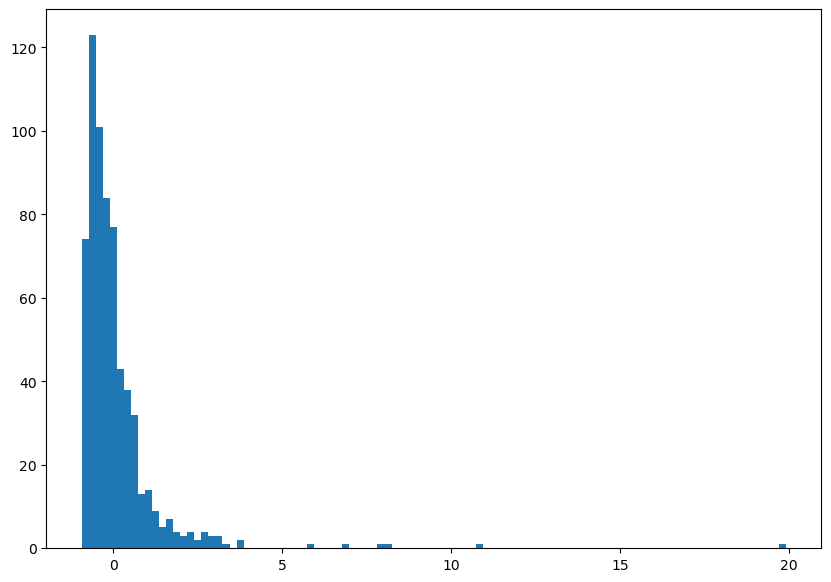

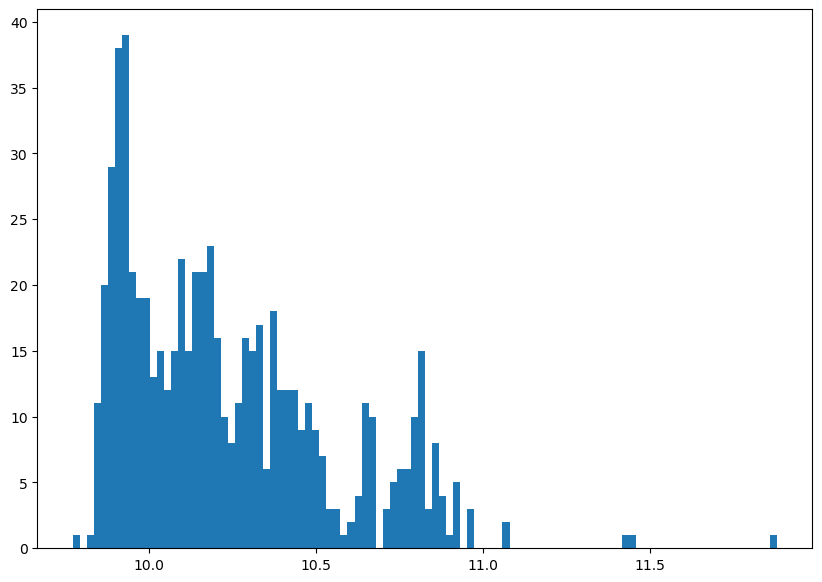

In [196]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

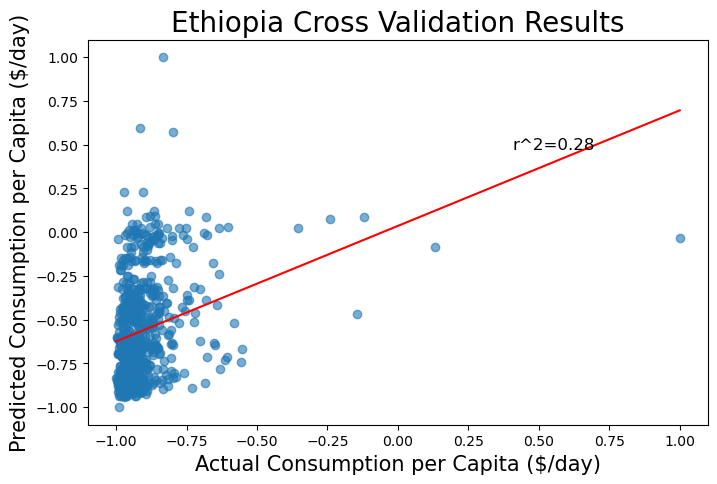

In [197]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()